<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/NN%20CNN%20epilepsy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://physionet.org/content/chbmit/1.0.0/chb01/#files-panel

In [1]:
!pip install pywavelets
!pip install mne
!pip install pywt
!pip install pyedflib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import mne
import pywt
import pyedflib
import pylab
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
import re
from scipy import signal
from scipy.fft import fft, fftfreq

ERROR: Could not find a version that satisfies the requirement pywt (from versions: none)
ERROR: No matching distribution found for pywt


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#подключаем (монтируем) к ноутубуку свой гугл-диск

from google.colab import drive
drive.mount('/content/drive')
import os
from os import listdir

#обратите внимание - надо указать путь до своей папки на гугл-диске
os.chdir('/content/drive/MyDrive/edf_process/CNN_NN_learning')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
def read_edf(file_path):
    with pyedflib.EdfReader(file_path) as f:
        n = f.signals_in_file
        signal_labels = f.getSignalLabels()
        signals = np.zeros((n, f.getNSamples()[0]))
        for i in range(n):
            signals[i, :] = f.readSignal(i)
    return signals, signal_labels

In [6]:
def save_wavelet_transform(signal, file_name, output_dir, start_time, end_time, sampling_rate, time_label):

    #scales = np.logspace(np.log10(scale_min), np.log10(scale_max), num = 25, endpoint=True, base=10.0)
    scale_max = [200, 50, 26, 14, 6]
    scale_min = [50, 26, 14, 6, 3.5]
    wavelet_core = 'morl'
    dt = 1 / sampling_rate
    leg = ["Delta", "Theta","Alpha", "Beta","Gamma"]
    #plt.figure(figsize = (10, 10))
    #plt.title(f'Wavelet Transform of {file_name}')
    #plt.axis('off')
    v_max = [240, 120, 40, 30, 20]
    # ax.set_title(f'Wavelet Transform of {file_name}')
    for k in range(len(signal)):
            scales = np.linspace(scale_min[k], scale_max[k], num=25, endpoint=True)
            coef, freqs = pywt.cwt(signal[k], scales, wavelet_core, sampling_period=dt)
            frequencies = pywt.scale2frequency(wavelet_core, scales) / dt
            # изобразим график зависимости частоты и масштаба
            # plt.figure(figsize=(7, 7))
            # plt.grid()
            # plt.yticks(np.arange(min(freqs), max(freqs), (max(freqs) - min(freqs))/10))
            # plt.xticks(np.arange(min(scales), max(scales), (max(scales) - min(scales))/10))
            # plt.ylabel('Частота[Герц]', fontsize=12)
            # plt.xlabel('масштаб в вейвлет преобразовании', fontsize=12)
            # plt.plot(scales, freqs,'.-')

            # Создаем кастомную цветовую карту от синего до красного с пределами мощности от 0 до 20
            colors = [(0, 'blue'), (0.5, 'cyan'), (0.9, 'yellow'), (1, 'darkred')]
            custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)
            ax = plt.subplot(5, 1, k + 1)

            extent = [start_time, end_time, frequencies[-1], frequencies[0]]  # Устанавливаем частоту на вертикальной оси
            # Используем фиксированные пределы vmin=0 и vmax=20
            img = ax.imshow(np.abs(coef), extent=extent, cmap=custom_cmap, aspect='auto', vmin=0, vmax=v_max[k])
            # plt.colorbar(label='Magnitude')
            ax.set_ylabel('Frequency (Hz)')
            ax.set_xlabel('Time (seconds)')
            # plt.axis('off')
            ax.set_ylim(frequencies[-1], frequencies[0])

            # Сохранение изображения
    output_path = os.path.join(output_dir, f'{file_name}_{time_label}_wavelet.png')
    plt.savefig(output_path)
    plt.show()
    plt.close()
    return output_path

In [7]:
def parse_summary_file(summary_file_path):
    edf_files = []
    with open(summary_file_path, 'r') as file:
        content = file.read()
        files = re.split(r'File Name: ', content)[1:]  # Разделение по файлам
        for file_info in files:
            lines = file_info.split('\n')
            file_name = lines[0].strip()
            seizure_start = []
            seizure_end = []
            num_seizures = 0
            k=0
            for line in lines[1:]:
                if 'Number of Seizures in File' in line:
                    num_seizures = int(line.split(':')[-1].strip())
                    k=num_seizures
                    continue

                if k > 0:
                    if ('Seizure' in line)and('Start Time' in line):
                        seizure_start_i = int(re.search(r'\d+', line.split(':')[-1].strip()).group())
                        seizure_start.append(seizure_start_i)
                        continue

                    if ('Seizure' in line)and('End Time' in line):
                        seizure_end_i = int(re.search(r'\d+', line.split(':')[-1].strip()).group())
                        seizure_end.append(seizure_end_i)
                        k-=1
                        continue

            edf_files.append({
                'file_name': file_name,
                'seizure_start': seizure_start,
                'seizure_end': seizure_end,
                'num_seizures': num_seizures
            })
    return edf_files


In [8]:
#процедура для фильтрации (выделению) из всего сигнала диапазонов частот
def butter_bandpass_filter(data, fs, plot_signal=False, order=5):
    # Определение диапазонов фильтрации
    lowcut = [1, 4, 8, 14, 30]
    highcut = [4, 8, 14, 20, 50]
    nyquist = 0.5 * fs
    # Список для хранения отфильтрованных сигналов
    filtered_signals = []
    # Фильтрация для каждого диапазона частот
    for i in range(len(lowcut)):
        low = lowcut[i] / nyquist
        high = highcut[i] / nyquist
        b, a = signal.butter(order, [low, high], btype='band')
        filtered_data = signal.lfilter(b, a, data)
        filtered_signals.append(filtered_data)
    # Построение спектров
    #plt.figure(figsize=(7, 5))
    leg = ["Delta", "Theta","Alpha", "Beta","Gamma"]
    for i, filtered_data in enumerate(filtered_signals):
        # Преобразование Фурье
        signal_fft = fft(filtered_data)
        # Амплитуды и частоты
        amplitudes = np.abs(signal_fft) / len(filtered_data)
        frequencies = fftfreq(len(filtered_data), 1 / fs)

        # Отбираем только положительные частоты
        positive_freqs = frequencies > 0
        frequencies = frequencies[positive_freqs]
        amplitudes = amplitudes[positive_freqs]

        # Построение графика спектра
        # Построение спектра
        #if plot_signal:
        #        plt.plot(frequencies, amplitudes, label = leg[i])
        #        plt.xlim([0, 60])
        #        plt.title("Спектр сигнала")
        #        plt.xlabel("Частота (Гц)")
        #        plt.ylabel("Амплитуда")
    #if plot_signal:
    #  plt.legend(loc='best')
    #  plt.tight_layout()
    #  plt.grid(which='minor')
    #  plt.show()

    return filtered_signals

In [9]:
# процедура выделения из всего сигнала окна для выгрузки части сионала
def measured(signal,window_size,sampling_time):
    window_size = int(window_size * sampling_time)
    a = 0
    b = window_size
    n = signal.size/window_size
    f_signal = np.copy(signal)
    for i in range(int(n)):
        a = i*window_size
        b = (i+1)*window_size
        f_signal[a:b] = signal[a:b] - np.mean(signal[a:b])
    return f_signal

# процедура осреднения сигнала - убираем постоянную составляющую
def mean_delete(filtered_alpha,window_count,sampling_rate,time,plot_signal=False):
    leg = ["Delta", "Theta","Alpha", "Beta","Gamma"]
    leg2 = ["Delta_m", "Theta_m","Alpha_m", "Beta_m","Gamma_m"]
    processed_signals = []
    plt.figure(figsize =(15,7))
    fig, axes = plt.subplots(5, 1, figsize=(12, 12))
    for i in range(5):
        filtered_1 = filtered_alpha[i]
        filtered_2 = measured(filtered_1,window_count,sampling_rate)
        processed_signals.append(filtered_2)
        if plot_signal:
          pylab.subplot (5, 1, i+1)
          plt.plot(time, filtered_1, label = leg[i])
          plt.plot(time, filtered_2, label = leg2[i])
          plt.legend(loc = "best")
          plt.xlim([2310, 2311])

    return processed_signals

# Make Dataset from EDF file

In [10]:
# Директория для сохранения изображений на Google Диске
output_dir = os.path.join(os.getcwd(), 'wavelet_img')
os.makedirs(output_dir, exist_ok=True)

In [11]:
# количество записей EDF
amount_of_rawedf = 24
os.chdir('/content')
!ls

drive  sample_data


In [15]:
for spisok in range(3,5,1):
  os.chdir('/content')
  #задаем путь до файла с описание ЭЭГ
  summary_file_path = '/physionet.org/files/chbmit/1.0.0/chb0%d/chb0%d-summary.txt' % (spisok+1, spisok+1)
  physionet_summary_file_url = 'https:/'+summary_file_path
  #зaкачиваем в ноутбук файл описание ЭЭГ
  !wget -r -c -N --no-parent -np $physionet_summary_file_url
  #распарсиваем записи из файла с описанием ЭЭГ на массив данных
  edf_files_list = parse_summary_file('/content'+summary_file_path)


  #edf_directory = os.chdir('/content/drive/MyDrive/edf_process/CNN_NN_learning')
  sampling_rate = 256
  window_count = 0.5
  flag = 0

  #основной цикл превращения EDF в изображение
  for edf_file in edf_files_list:
    os.chdir('/content')
    edf_directory = '/physionet.org/files/chbmit/1.0.0/chb0%d/' % (spisok+1)
    edf_file_link = f"{'https:/'}{edf_directory}{edf_file['file_name']}"
    #загружаем EDF в ноутбук
    !wget -r -c -N -np $edf_file_link

    #записывам сигналы и метки ЭЭГ в переменные
    edf_file_path = f"{'/content'}{edf_directory}{edf_file['file_name']}"
    signals, labels = read_edf(edf_file_path)

    # Если есть приступ, генерируем изображения для 3 временных интервалов
    if len(edf_file['seizure_start']) != 0:
      flag = 1
      seizure_times = [(30, '30_sec_before'), (30, '60_sec_before'), (30, '90_sec_before')]
      number = 1
      for seiz_time in range(len(edf_file['seizure_start'])):
        seizure_st = edf_file['seizure_start'][seiz_time]
        seizure_en = edf_file['seizure_end'][seiz_time]
        for time_offset, time_label in seizure_times:
          time_window_start = seizure_st - time_offset
          time_window_end = seizure_st  # Окно в 30 секунд
          seizure_st = seizure_st- 30
          time_window_start_samples = time_window_start * sampling_rate
          time_window_end_samples = time_window_end * sampling_rate
          signal_s = np.delete(signals, [len(signals)-1], axis=0)
          time = np.arange(time_window_start, time_window_end, 1/sampling_rate)

          # Усреднение сигналов
          avg_signal = np.zeros(time_window_end_samples - time_window_start_samples)
          for i in range(len(signals)-1):
            avg_signal += signal_s[i, time_window_start_samples:time_window_end_samples]
          avg_signal /= len(signals)

          # Применение фильтра Баттерворта
          filtered_data = butter_bandpass_filter(avg_signal, sampling_rate, plot_signal=False)
          filtered_mean = mean_delete(filtered_data, window_count, sampling_rate,time,plot_signal=False)

          # Определяем директорию и путь для сохранения изображения
          os.chdir('/content/drive/MyDrive/edf_process/CNN_NN_learning/wavelet_img')
          save_dir = os.path.join(output_dir, 'Seizure')
          os.makedirs(save_dir, exist_ok=True)

          # Сохранение изображения
          image_path = f"{edf_file['file_name']}_{time_label}_{number}_wavelet.png"
          save_wavelet_transform(filtered_mean, image_path, save_dir,
                                            time_window_start, time_window_end, sampling_rate,time_label)
          number+=1
    else:
      # Обработка для записей без приступа (Healthy)
      flag = 0
      #приступов нет, поэтому выбираем любое значение времени для выгрузки ЭЭГ
      #time_window_start = 2300
      time_window_start = int(signals.shape[1]/sampling_rate/2)
      #time_window_end = 2330
      time_label = 30 #ширина окна для выгрузки данных
      time_window_end = time_window_start + time_label

      time_window_start_samples = time_window_start * sampling_rate
      time_window_end_samples = time_window_end * sampling_rate
      signals = np.delete(signals, [len(signals)-1], axis=0)
      time = np.arange(time_window_start, time_window_end, 1/sampling_rate)
      # Усреднение сигналов
      avg_signal = np.zeros(time_window_end_samples - time_window_start_samples)
      for i in range(len(signals)-1):
        # Проходим по всем каналам
        avg_signal += signals[i, time_window_start_samples:time_window_end_samples]
        avg_signal /= len(signals)  # Среднее значение по всем каналам
      #for s in signals:
      #  plt.plot(time, s[time_window_start_samples:time_window_end_samples])
      #plt.plot(time,  avg_signal, label = 'Усредненный сигнал')
      #plt.legend(loc = 'best')
      #plt.xlabel("Время, [с]")
      #plt.ylabel("Амплитуда")
      #plt.savefig(output_dir)

      # Фильр Баттерворта
      filtered_data = butter_bandpass_filter(avg_signal, sampling_rate, plot_signal=False)
      #i = 0
      #plt.figure(figsize =(15,7))
      #leg = ["Delta", "Theta","Alpha", "Beta","Gamma"]
      #fig, axes = plt.subplots(5, 1, figsize=(12, 12))
      #for s in filtered_data:
      #  ax = plt.subplot(5, 1, i + 1)
      #  plt.plot(time, s, label=leg[i])
      #  plt.grid()
      #  plt.legend(loc = "best")
      #  i = i+1
      #plt.xlabel("Время, [с]")
      #spectr = os.path.join(output_dir, "spectr.png")
      #plt.savefig(spectr,bbox_inches='tight')
      # plt.ylabel("Амплитуда")
      #plt.close()

      # Удаление среднего скользящим окном
      filtered_mean = mean_delete(filtered_data, window_count, sampling_rate,time, plot_signal=False)

      # Определяем директорию и путь для сохранения изображения
      save_dir = os.path.join(output_dir, 'Healthy')
      os.makedirs(save_dir, exist_ok=True)
      #image_path = os.path.join(save_dir, f"{edf_file['file_name']}_{time_label}_wavelet.png")
      image_path = f"{edf_file['file_name']}_{time_label}_wavelet.png"

      # Сохранение изображения
      save_wavelet_transform(filtered_mean, image_path,
                                            save_dir,time_window_start,
                                            time_window_end, sampling_rate,time_label)
  import shutil
  shutil.rmtree('/content/physionet.org')

--2024-12-02 14:49:15--  https://physionet.org/files/chbmit/1.0.0/chb04/chb04-summary.txt
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5645 (5.5K) [text/plain]
Saving to: ‘physionet.org/files/chbmit/1.0.0/chb04/chb04-summary.txt’

physionet.org/files 100%[===================>]   5.51K  --.-KB/s    in 0s      

2024-12-02 14:49:15 (875 MB/s) - ‘physionet.org/files/chbmit/1.0.0/chb04/chb04-summary.txt’ saved [5645/5645]

FINISHED --2024-12-02 14:49:15--
Total wall clock time: 0.3s
Downloaded: 1 files, 5.5K in 0s (875 MB/s)
--2024-12-02 14:49:15--  https://physionet.org/files/chbmit/1.0.0/chb04/chb04_01.edf
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169556992 (162M) [application/octet-stream]
Saving to: ‘physion

OSError: /content/physionet.org/files/chbmit/1.0.0/chb04/chb04_01.edf: the file is not EDF(+) or BDF(+) compliant (Filesize)

In [ ]:
!ls

drive  physionet.org  sample_data


In [ ]:
import shutil
shutil.rmtree('/content/physionet.org')

# Convolution Neural Network Model

In [5]:
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, Reshape, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight, shuffle
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model

## Load train and test dataset

In [2]:
# Функция для загрузки изображений
def load_images(image_dir, target_size):
    images = []
    labels = []
    for class_dir in ['Healthy', 'Seizure']:  # Подкаталоги классов
        class_path = os.path.join(image_dir, class_dir)
        label = 0 if class_dir == 'Healthy' else 1  # Классы кодируются как 0 или 1
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = plt.imread(img_path)
            # plt.figure()
            # plt.imshow(img)
            img = tf.image.resize(img, target_size)  # Изменение размеров изображения
            images.append(img)
            labels.append(label)
    plt.show()
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [3]:
# Функция для вывода изображений с метками
def display_samples(X, y, num_samples, dataset_name="Dataset"):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        # plt.subplot(1, num_samples, i + 1)
        plt.imshow(X[i,:,:,:])
        plt.title(f"Label: {np.argmax(y[i])}")
        plt.axis('off')
    plt.suptitle(f"Sample images from {dataset_name}")
    plt.show()

In [8]:
# Путь к директории с изображениями
image_dir = '/content/drive/MyDrive/edf_process/CNN_NN_learning/wavelet_img/'
os.chdir(image_dir)


# Загрузка данных
#X, y = load_images(image_dir, (700,700))
X, y = load_images(image_dir, (256,256))
# print(X[1,32,32,:])
# Масштабирование изображений (нормализация)
# X = X / 255.0
X, y = shuffle(X, y, random_state=24)
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
# Преобразование меток в категориальный формат (one-hot encoding)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

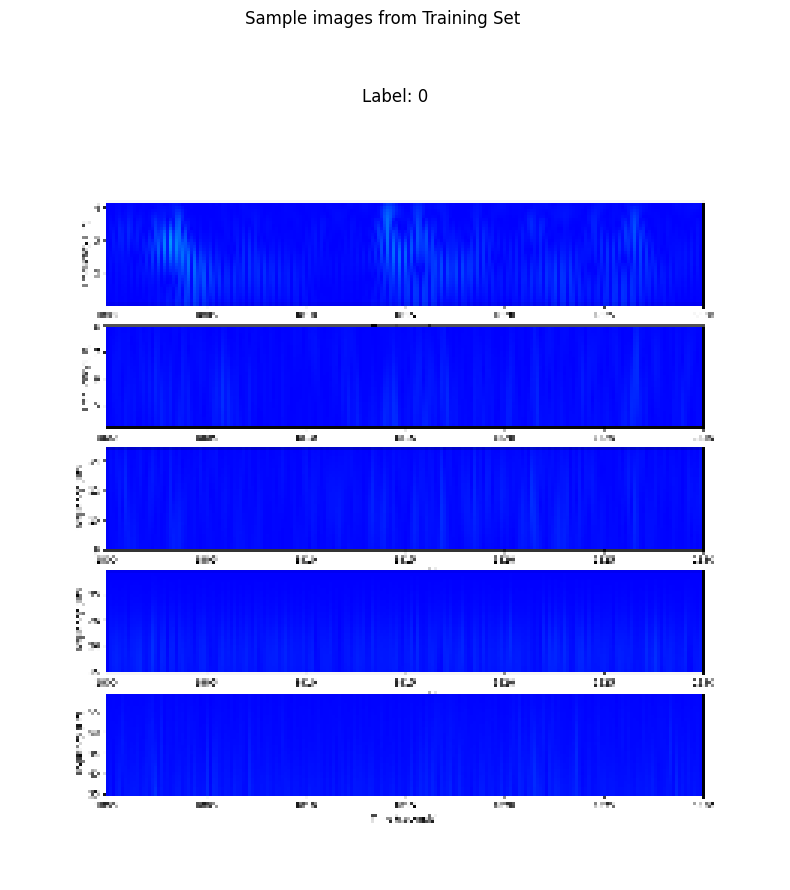

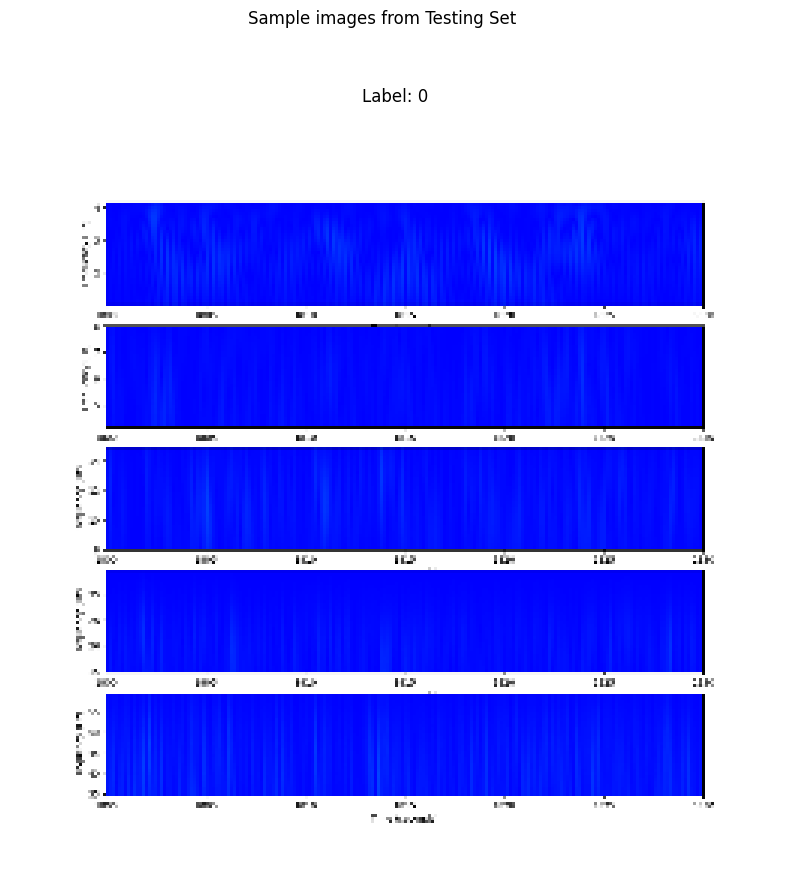

In [10]:

# Вывод примеров из тестовой выборки
# Вывод примеров из обучающей выборки
display_samples(X_train, y_train, num_samples=3, dataset_name="Training Set")
display_samples(X_test, y_test, num_samples=3, dataset_name="Testing Set")



## Create model

In [12]:
# Создание модели CNN-LSTM
def create_cnn_lstm_model(input_shape):
    model = Sequential()
    # Cверточные слои
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.3))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.5))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))


    # Преобразование для LSTM
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.05)))  # Регуляризация L2
    # model.add(Dropout(0.5))
    model.add(Reshape((1, -1)))  # Преобразуем в последовательность длины 1 для LSTM
    model.add(LSTM(128, return_sequences=False))  # Первый LSTM слой
    # model.add(Dropout(0.3))

    # Полносвязный слой
    model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.05)))
    # model.add(Dropout(0.5))

    # Выходной слой для двух классов
    model.add(Dense(2, activation='sigmoid'))  # Для классификации на 2 класса

    # Компиляция модели
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Инициализация модели
input_shape = (256, 256, 4)  # Изображения 64x64 с 3 каналами (RGB)
model = create_cnn_lstm_model(input_shape)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 256, 256, 64)        │           2,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256, 256, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 262144)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │      33,554,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,066,178 (129.95 MB)

 Trainable params: 34,066,050 (129.95 MB)

 Non-trainable params: 128 (512.00 B)

In [14]:
# Обучение модели

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=40, restore_best_weights=True)
# Преобразование меток обратно из one-hot encoding в одномерный массив меток

y_train_classes = np.argmax(y_train, axis=1)

# Вычисление весов классов
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_classes), y=y_train_classes)

# Преобразование class_weights в словарь, так как model.fit ожидает словарь
class_weights_dict = dict(enumerate(class_weights))
checkpoint = ModelCheckpoint(
    "best_weights.keras",  # Имя файла для сохранения весов
    monitor="val_accuracy",  # Метрика для отслеживания
    save_best_only=True,     # Сохранять только если улучшилась метрика
    mode="max",              # "max" для максимизации метрики
    verbose=1
)
# Обучение модели с указанием весов классов
history = model.fit(X_train, y_train, epochs=20, batch_size=8, validation_split=0.2, class_weight=class_weights_dict, callbacks=[early_stopping] )
# Оценка модели на тестовых данных
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Печать результатов оценки
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))
print("Accuracy:", accuracy_score(y_true, y_pred_classes))


Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 120s 6s/step - accuracy: 0.9664 - loss: 2.9181 - val_accuracy: 0.9429 - val_loss: 1.8255
Epoch 2/20
 6/18 ━━━━━━━━━━━━━━━━━━━━ 1:37 8s/step - accuracy: 0.9490 - loss: 1.5987

KeyboardInterrupt: 

In [15]:
y_pred_classes

array([0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0])

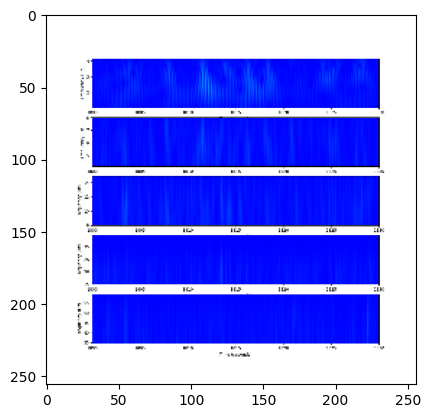

In [16]:
#y_pred = model.predict(X_test)
plt.imshow(X_test[9])

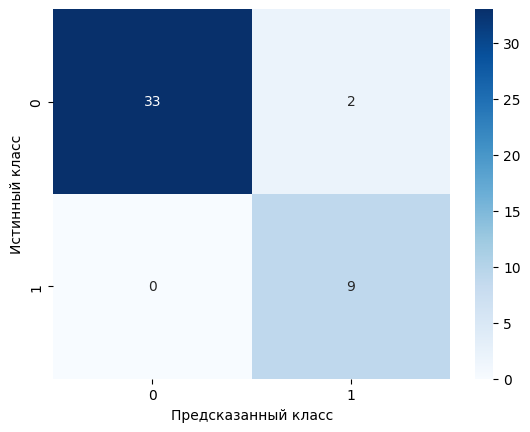

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [17]:
# Построение матрицы ошибок
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
class_names = ['Содержащий приступ', 'Не содержащий приступ']
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()
plt.figure()

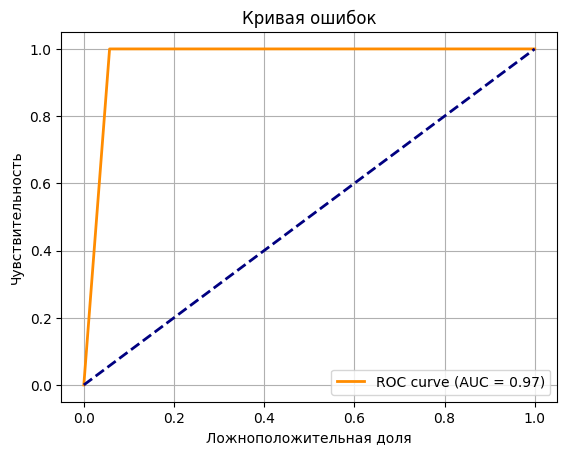

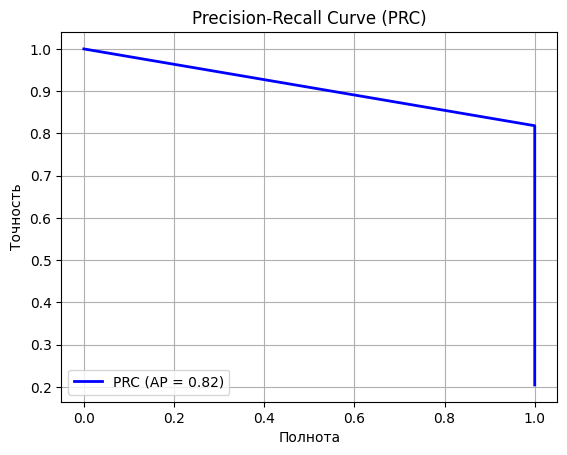

In [18]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Построение ROC-кривой
fpr, tpr, _ = roc_curve(y_true, y_pred_classes)  # Используем вероятности для классов

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Диагональная линия
plt.xlabel('Ложноположительная доля')
plt.ylabel('Чувствительность')
plt.title('Кривая ошибок')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Построение Precision-Recall кривой
precision, recall, _ = precision_recall_curve(y_true, y_pred_classes)
average_precision = average_precision_score(y_true, y_pred_classes)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PRC (AP = {average_precision:.2f})')
plt.xlabel('Полнота')
plt.ylabel('Точность')
plt.title('Precision-Recall Curve (PRC)')
plt.legend(loc='lower left')
plt.grid()
plt.show()

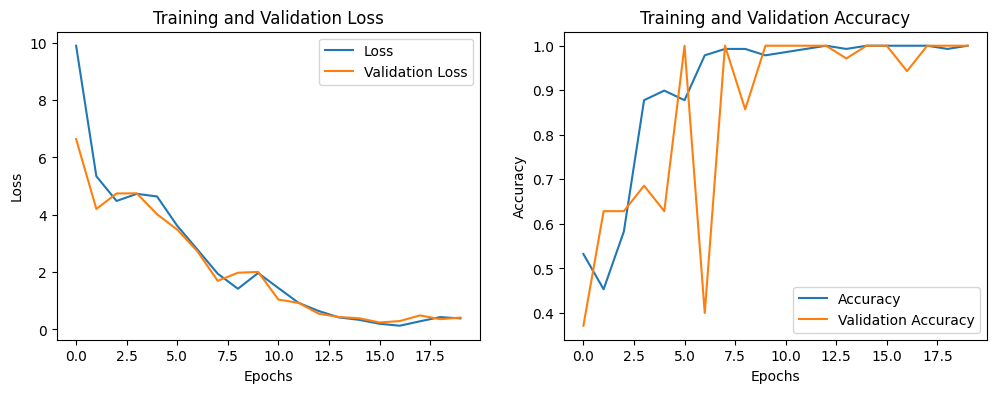

In [19]:
# Визуализация обучения
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

plt.close()  # Закрыть график, чтобы избежать наложения

In [69]:
#сохранение модели
model.save('cnn_eeg_epilepsy_model.h5')
#model_loaded = tf.keras.models.load_model('cnn_eeg_epilepsy_model.h5')


In [71]:
# Сохранение весов
model.save_weights("model_weights.weights.h5")

# Загрузка весов в ту же архитектуру модели
#model.load_weights("model_weights.h5")